<a href="https://www.kaggle.com/code/lukalafaye/gan-mnist-dslab2?scriptVersionId=202320764" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
os.environ['PYTHON_PATH'] = "/kaggle/working/"

In [2]:
!cp /kaggle/input/dslab2/* /kaggle/working/
!ls /kaggle/working/

__init__.py  model.py  requirements.txt  utils.py


In [3]:
from model import Generator
from utils import load_model

In [4]:
import torch 
import torchvision
import os
import argparse

In [5]:
args = argparse.Namespace(batch_size=20)  # Set default value

print('Model Loading...')
# Model Pipeline
mnist_dim = 784

model = Generator(g_output_dim = mnist_dim).cuda()
model = load_model(model, '/kaggle/input/g/pytorch/default/3')
model = torch.nn.DataParallel(model).cuda()
model.eval()

print('Model loaded.')



print('Start Generating')
os.makedirs('samples', exist_ok=True)

image_paths = []

n_samples = 0
with torch.no_grad():
    while n_samples<10000:
        z = torch.randn(args.batch_size, 100).cuda()
        x = model(z)
        x = x.reshape(args.batch_size, 28, 28)
        for k in range(x.shape[0]):
            if n_samples<10000:
                image_path = os.path.join('samples', f'{n_samples}.png')
                torchvision.utils.save_image(x[k:k+1], image_path)         
                image_paths.append(image_path)  # Store image path
                n_samples += 1

Model Loading...


/kaggle/working/utils.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(folder, f'{model_type}.pth'), map_location=device)  # Load model to

Model loaded.
Start Generating


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/linear.py:117: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)


In [6]:
from IPython.display import display, Image

for img_path in image_paths[:50]:  # Slice to get only the first 10 images
    display(Image(filename=img_path))

cuda
Dataset loading...
Dataset Loaded.
Model Loading...
Model loaded.
Start Training:


  0%|          | 0/400 [00:00<?, ?it/s]

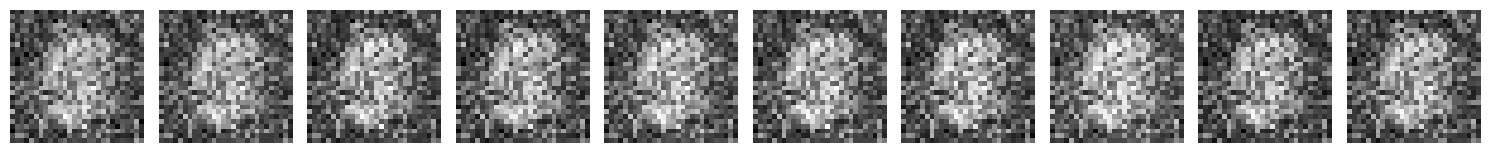

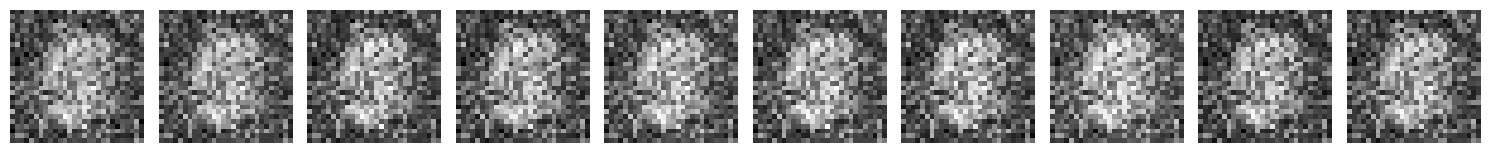

  0%|          | 1/400 [00:10<1:08:28, 10.30s/it]

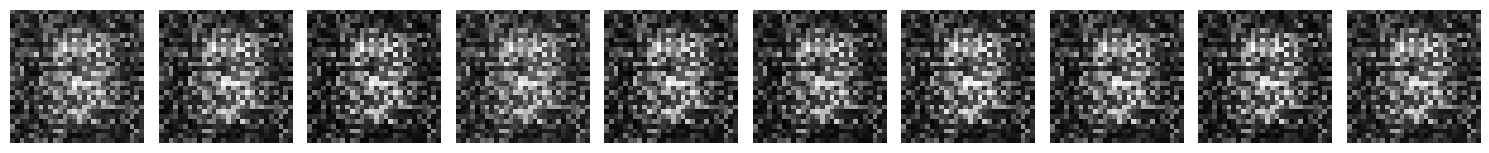

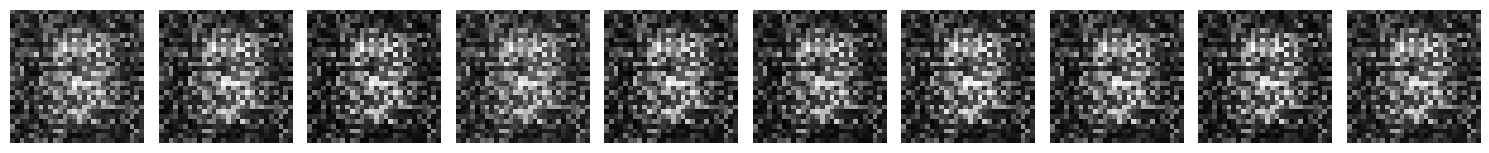

  0%|          | 2/400 [00:20<1:07:45, 10.22s/it]

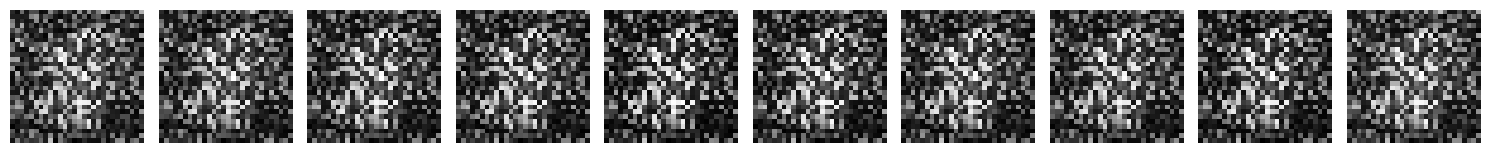

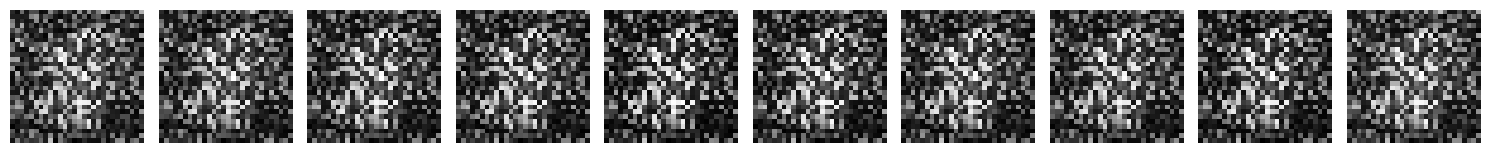

  1%|          | 3/400 [00:30<1:07:39, 10.22s/it]

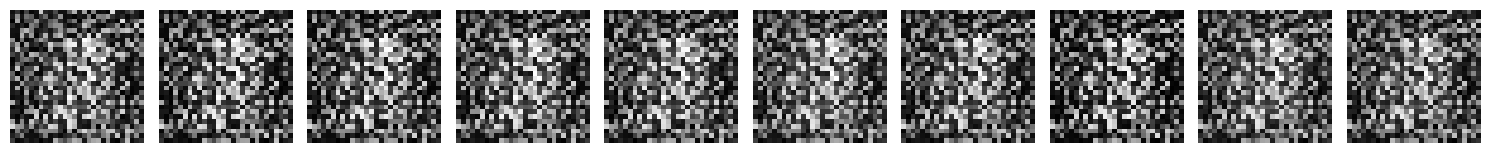

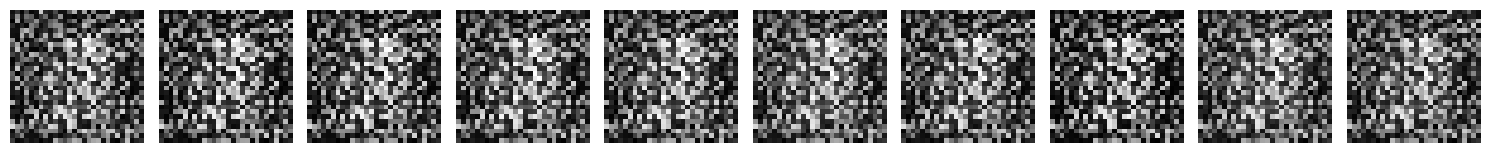

  1%|          | 4/400 [00:41<1:07:49, 10.28s/it]

In [ ]:
import torch 
import os
from tqdm import trange
import argparse
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from model import Generator, Discriminator
from utils import D_train, G_train, save_models
from IPython.display import display 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

parser = argparse.ArgumentParser(description='Train Normalizing Flow.')
parser.add_argument("--epochs", type=int, default=400, help="Number of epochs for training.")
parser.add_argument("--lr", type=float, default=0.00001, help="The learning rate to use for training.")
parser.add_argument("--batch_size", type=int, default=256, help="Size of mini-batches for SGD")
args = parser.parse_args(args=[])

os.makedirs('checkpoints', exist_ok=True)
os.makedirs('data', exist_ok=True)

print('Dataset loading...')
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root='data/MNIST/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='data/MNIST/', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=args.batch_size, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=args.batch_size, shuffle=False, num_workers=8)
print('Dataset Loaded.')

print('Model Loading...')
mnist_dim = 784
G = torch.nn.DataParallel(Generator(g_output_dim=mnist_dim)).to(device)
D = torch.nn.DataParallel(Discriminator(mnist_dim)).to(device)
print('Model loaded.')

criterion = nn.BCELoss().to(device)
G_optimizer = optim.Adam(G.parameters(), lr=args.lr)
D_optimizer = optim.Adam(D.parameters(), lr=args.lr)

print('Start Training:')

def plot_generated_images(generator, epoch, num_images=10):
    """Function to plot and display generated images from the generator."""
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, 100).to(device)
        generated_images = generator(noise)
        generated_images = generated_images.view(-1, 1, 28, 28).cpu()

        fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
        for ax, img in zip(axes, generated_images):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        display(fig) 
        plt.show() 

n_epoch = args.epochs
for epoch in trange(1, n_epoch + 1, leave=True):
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(-1, mnist_dim).to(device)
        
        D_loss = D_train(x, G, D, D_optimizer, criterion)
        G_loss = G_train(x, G, D, G_optimizer, criterion)

    if epoch % 1 == 0:
        save_models(G, D, 'checkpoints')
        plot_generated_images(G, epoch)  # Plot images after every 10 epochs

print('Training done')

In [ ]:
torch.save(G.state_dict(), 'generator2.pth')